In [7]:
import numpy as np
import matplotlib.pyplot as plt
from node import Node

In [8]:
mnist_data = np.load('mnist.npz')
X_train = mnist_data['x_train']
y_train = mnist_data['y_train']
x_test = mnist_data['x_test']
y_test = mnist_data['y_test']

mask = (y_train <3)
X_train = X_train[mask]
y_train = y_train[mask]

mask2=(y_test <3)
x_test = x_test[mask2]
y_test = y_test[mask2]
import numpy as np

def pca_transform(data, n_components=10):
    # Reshape the data if necessary
    data = data.reshape(data.shape[0], -1)
    
    # Calculate mean
    mean = np.mean(data, axis=0)
    
    # Center the data
    data_centered = data - mean
    
    # Calculate covariance matrix
    cov_matrix = np.cov(data_centered, rowvar=False)
    
    # Compute eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    
    # Select top n_components eigenvectors
    pca_matrix = eigenvectors_sorted[:, :n_components]
    
    # Project data onto the principal components
    data_reduced = np.dot(data_centered, pca_matrix)
    
    return data_reduced, pca_matrix

# Example usage:
# Assuming X_train and x_test are your datasets
X_reduced, pca_matrix = pca_transform(X_train, n_components=10)
print("PCA Matrix shape for X_train:", pca_matrix.shape)
print("Reduced X_train shape:", X_reduced.shape)

X_reduced1, pca_matrix1 = pca_transform(x_test, n_components=10)
print("PCA Matrix shape for x_test:", pca_matrix1.shape)
print("Reduced x_test shape:", X_reduced1.shape)
i =1000;



PCA Matrix shape for X_train: (784, 10)
Reduced X_train shape: (18623, 10)
PCA Matrix shape for x_test: (784, 10)
Reduced x_test shape: (3147, 10)


In [9]:
# def pca(data, n_components=10):
#     data_mean = np.mean(data, axis=0)
#     data_centered = data - data_mean
#     covariance_matrix = np.cov(data_centered, rowvar=False)
#     eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
#     # Step 5: Sort eigenvectors and eigenvalues in descending order
#     sorted_indices = np.argsort(eigenvalues)[::-1]
#     sorted_eigenvalues = eigenvalues[sorted_indices]
#     sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
#     # Step 6: Choose top n_components eigenvectors
#     U = sorted_eigenvectors[:, :n_components]
    
#     # Step 7: Project the data onto the top n_components eigenvectors
#     Y = np.dot(U.T, data_centered.T)
#     # Step 9: Further reduce dimensionality if needed
#     Up = U[:, :n_components]
#     data_reduced = np.dot( data_centered , Up)
    
#     return data_reduced
# pca_matrix = pca(X_train, n_components=10)
# print(pca_matrix.shape)
# pca_matrix_test= pca(x_test, n_components=10)
# print(pca_matrix_test.shape)
# # plotting the graph
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap='viridis')

In [26]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth 
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        print(best_split["feature_index"])
    
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def gini_index(self, y): 
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):   
        Y = list(Y)
        return max(Y, key=Y.count)
    def fit(self, X, Y):  
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):  
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    def print_tree(self, tree=None, indent=" "):
        if tree is None:
            tree = self.root

        if tree.value is not None:
            print(tree.value)
        else:
            print(f"X{tree.feature_index} <= {tree.threshold}")
            print(f"{indent}Left:", end="")
            self.print_tree(tree.left, indent + " ")
            print(f"{indent}Right:", end="")
            self.print_tree(tree.right, indent + " ")
    def get_num_nodes(self):
        self.count_nodes(self.root)
        print(self.num_nodes)
        return self.num_nodes

In [14]:
pip install graphviz

   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------------- 47.1/47.1 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


0
1
0
4
2
7
1
X0 <= (624.6639084076754+0j)
 Left:X1 <= (179.67561986817165+0j)
  Left:X0 <= (-202.45652113486+0j)
   Left:0j
   Right:(2+0j)
  Right:X4 <= (-720.989887611521+0j)
   Left:0j
   Right:(2+0j)
 Right:X2 <= (231.62107754431926+0j)
  Left:X7 <= (-575.7336812339529+0j)
   Left:(2+0j)
   Right:(1+0j)
  Right:X1 <= (-480.6481292874099+0j)
   Left:(1+0j)
   Right:(2+0j)
<bound method DecisionTreeClassifier.get_num_nodes of <__main__.DecisionTreeClassifier object at 0x0000016C5205D9A0>>
Overall Accuracy: 0.6619002224340642
Class-wise accuracies: {0: 0.32857142857142857, 1: 0.9145374449339208, 2: 0.7005813953488372}
   Class  Accuracy
1      1  0.914537
2      2  0.700581
0      0  0.328571


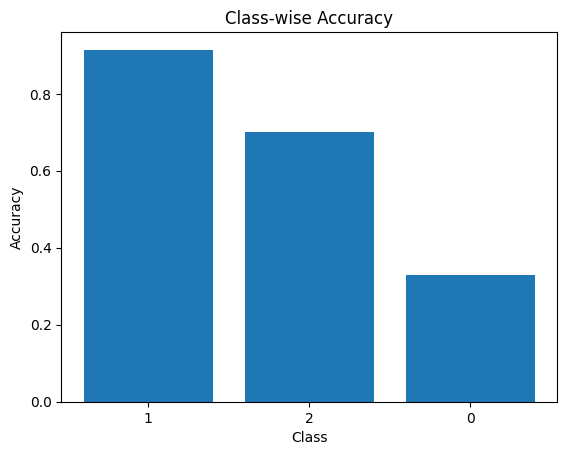

In [27]:
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Reshape y_train to match classifier's requirements
y_train = y_train.reshape(-1, 1)

# Instantiate the DecisionTreeClassifier with desired parameters
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=2)

# Fit the classifier on the reduced training data
classifier.fit(X_reduced[:i], y_train[:i])
# Predict the labels for the test data
classifier.print_tree()
print(classifier.get_num_nodes)
Y_pred = classifier.predict(np.real(X_reduced1))

# Calculate the overall accuracy
overall_accuracy = accuracy_score(y_test, np.real(Y_pred))

print("Overall Accuracy:", overall_accuracy)

# Calculate class-wise accuracies
class_accuracies = {}
for c in np.unique(y_test):
    class_mask = (y_test == c)
    class_accuracy = accuracy_score(y_test[class_mask], np.real(Y_pred)[class_mask])
    class_accuracies[c] = class_accuracy

print("Class-wise accuracies:", class_accuracies)

# Convert class-wise accuracies to DataFrame and sort
class_accuracies_df = pd.DataFrame(class_accuracies.items(), columns=['Class', 'Accuracy'])
class_accuracies_df = class_accuracies_df.sort_values('Accuracy', ascending=False)

print(class_accuracies_df)
# Plotting
fig, ax = plt.subplots()
ax.bar(range(len(class_accuracies_df)), class_accuracies_df['Accuracy'], align='center')
ax.set_xticks(range(len(class_accuracies_df)))
ax.set_xticklabels(class_accuracies_df['Class'])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Class')
ax.set_title('Class-wise Accuracy')
plt.show()


0
1
0
4
2
0
0
0
1
5
2
0
0
1
0
0
2
0
0
1
0
4
2
0
0
1
0
4
0
Total Accuracy: 0.6310772163965681
Class 0 Accuracy: 0.26224489795918365
Class 1 Accuracy: 0.8828193832599119
Class 2 Accuracy: 0.7044573643410853


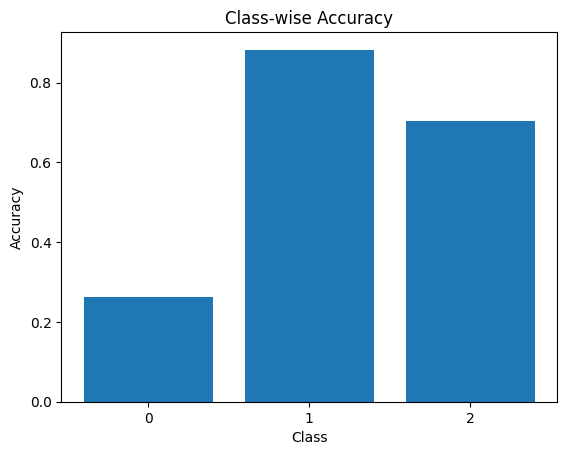

In [12]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def perform_bagging_and_voting(X_train, y_train, X_test, num_samples=5):

    datasets = []
    for i in range(num_samples):
        indices = np.random.choice(len(X_train), 100, replace=True)
        X_sample, y_sample = X_train[indices], y_train[indices]
        datasets.append((X_sample, y_sample))
    trees = []
    for X_sample, y_sample in datasets:
        tree = DecisionTreeClassifier(min_samples_split=3, max_depth=2)
        tree.fit(X_sample, y_sample)
        trees.append(tree)

    predictions = []
    for tree in trees:
        prediction = tree.predict(X_test)
        predictions.append(prediction)
    majority_votes = np.array(predictions)
    majority_votes = np.swapaxes(majority_votes, 0, 1)
    final_predictions = []
    for votes in majority_votes:
        vote_count = Counter(votes)
        final_predictions.append(vote_count.most_common(1)[0][0])
    
    return final_predictions

# Perform bagging and voting
final_predictions = perform_bagging_and_voting(X_reduced[:i], y_train[:i], X_reduced1)

# Calculate total accuracy
total_accuracy = np.mean(final_predictions == y_test)

# Calculate class-wise accuracies
class_accuracy = {}
for class_label in np.unique(y_test):
    correct = np.sum((final_predictions == y_test) & (y_test == class_label))
    total = np.sum(y_test == class_label)
    class_accuracy[class_label] = correct / total

# Report the results
print("Total Accuracy:", total_accuracy)
for class_label, accuracy in class_accuracy.items():
    print(f"Class {class_label} Accuracy:", accuracy)

# Plotting
fig, ax = plt.subplots()
ax.bar(range(len(class_accuracy)), list(class_accuracy.values()), align='center')
ax.set_xticks(range(len(class_accuracy)))
ax.set_xticklabels(list(class_accuracy.keys()))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Class')
ax.set_title('Class-wise Accuracy')
plt.show()
